# Where are we running?
It's always cool to work on data very close to us, in this case I mean the running tracks around the office. The simple and direct visualisation consists in plotting all the trails on the map and add a *heatmap* or *hexbin* layer to see the spatial density.      
Here I try to explore other possibilities.

In [1]:
import gpxpy
import gpxpy.gpx
import numpy as np
import os
import glob
import logging
from geopy import distance
from geo import sphere
import matplotlib.pyplot as plt
import cmocean
import matplotlib.patheffects as PathEffects
import GPX2dist_angle_histogram

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.info("starting")

INFO:root:starting


## Read the data
First thing first: get the data. GPX is a wide-spread format and [`gpxpy`] the perfect tool to read the files. 

### Available data
I have tracks since 2013, though most of them are concentrated in 2017-2018.      
The total is about 340 files.

In [4]:
basedir = "../data/"
figdir = "../images/"
filelist = []
for yy in [2017,2018,2019]:
    gpxdir = "".join((basedir, str(yy)))
    filelist.extend(sorted(glob.glob(os.path.join(gpxdir, "*.gpx"))))
    logging.info("Working on {} GPX files".format(len(filelist)))

INFO:root:Working on 59 GPX files
INFO:root:Working on 124 GPX files
INFO:root:Working on 152 GPX files


### Processing
We will compute 
* the distance to a central point, located close to our offices, 
* the direction with (e.g. northward, southward, eastward, ...) with respect to the starting point
* the altitude.

The loop can half a minute or so.

In [5]:
distancevec = []
bearingvec = []
elevations = np.array([])
lon0, lat0, ele0 = 5.565, 50.582, 240.
for gpxfile in filelist:
    fname = os.path.basename(gpxfile)
    #logger.debug("Working on file {}".format(fname))
    
    # Check file size
    if os.stat(gpxfile).st_size > 0:
        lon, lat, ele = get_coords(gpxfile)
        elevations = np.append(elevations, ele)
        
        for i in range(0, len(lon)):
            # Compute distance between with respect to 1st point
            d = distance.vincenty((lat0,lon0), (lat[i], lon[i])).kilometers
            distancevec.append(d)
            bearingvec.append(sphere.bearing((lat0,lon0), (lat[i], lon[i])))
    else:
        logger.debug("File is empty")
        os.remove(gpxfile)

To do: write the coordinates in a format readable by `DIVA`.

In [6]:
with open("../data/GPXdiva.dat", "w") as f:
    for gpxfile in filelist:
        fname = os.path.basename(gpxfile)
        #logger.debug("Working on file {}".format(fname))

        # Check file size
        if os.stat(gpxfile).st_size > 0:
            lon, lat, ele = get_coords(gpxfile)
            elevations = np.append(elevations, ele)   

## Figures
### Direction histogram
We start with an histogram to display the most frequent zone with respect to the starting point.

In [7]:
thetabins = np.arange(0, 2*np.pi+.001, np.pi/4.) + np.pi/8.
bearingvec2 = np.deg2rad(bearingvec)
elevationbins = np.arange(100, 325., 25.)

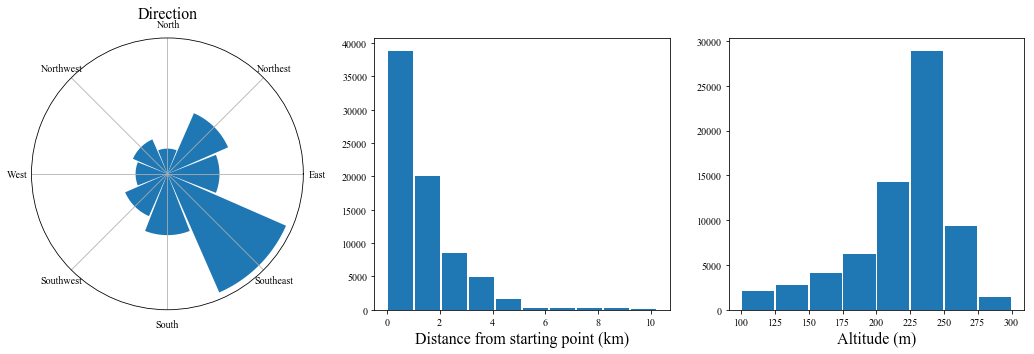

In [14]:
fig = plt.figure(figsize=(18, 5))
ax = plt.subplot(131, projection='polar')
plt.title("Direction", fontsize=16)
plt.hist(bearingvec2, bins=thetabins, rwidth=0.95)
lines, labels = plt.thetagrids( range(0,360,45), ('East', 'Northest', 'North', 'Northwest', 
                                                  'West','Southwest', 'South', 'Southeast') )

lines, labels = plt.rgrids([])
ax = plt.subplot(132)
plt.xlabel("Distance from starting point (km)", fontsize=16)
plt.hist(distancevec, rwidth=0.95)
ax = plt.subplot(133)
plt.hist(elevations, bins=elevationbins, rwidth=0.95)
plt.xlabel("Altitude (m)", fontsize=16)
plt.savefig(os.path.join(figdir, 'gpx_histogram.png'), dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'gpx_histogram.jpg'), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

We directly see that we spend more time in the southeast sector, which makes sense knowing that the track is located there.

### Positions in polar coordinates 
In this figure we simply plot the different tracks in the new coordinate system.

In [8]:
pointsInterest = [
    [50.552, 5.5502, "Roche aux Faucons"],
    [50.6024, 5.5957, "Lande de Streupas"],
    [50.5818, 5.6027, "Rochers du bout du monde"],
    [50.6007, 5.5554, "Point de vue"],
    [50.577784, 5.573265, "Piste du Blanc Gravier"],
    ];

INFO:root:Roche aux Faucons
INFO:root:Lande de Streupas
INFO:root:Rochers du bout du monde
INFO:root:Point de vue
INFO:root:Piste du Blanc Gravier


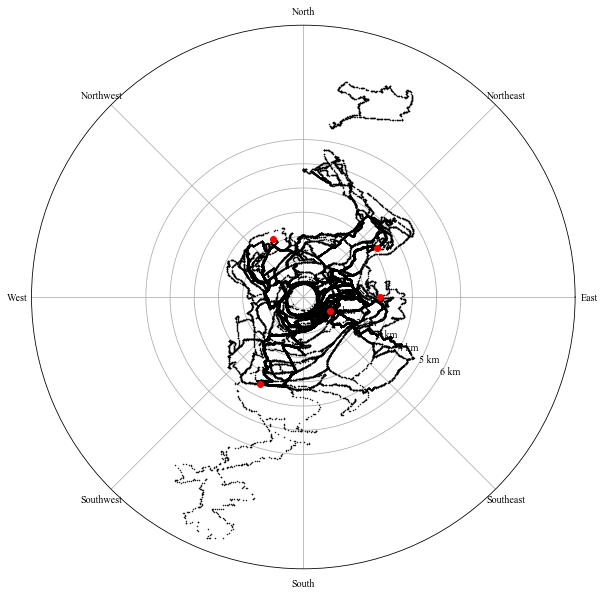

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
plt.plot(bearingvec2, distancevec, "ko", ms=.5)
for p in pointsInterest:
    logger.info(p[-1])
    bearing = np.deg2rad(sphere.bearing((lat0, lon0), (p[0], p[1])))
    dist = distance.vincenty((lat0, lon0), (p[0], p[1])).kilometers
    plt.plot(bearing, dist, "ro")
lines, labels = plt.thetagrids( range(0,360,45), ('East', 'Northeast', 'North', 'Northwest', 
                                                  'West','Southwest', 'South', 'Southeast') )

lines, labels = plt.rgrids( np.arange(0., 6.1, 1.0), 
                           ("", "1 km", "2 km", "3 km", "4 km", "5 km", "6 km" ),
                          angle=-30.)
#plt.savefig(os.path.join(figdir, 'polar_trajectories_poi.png'), dpi=300, bbox_inches="tight")
#plt.savefig(os.path.join(figdir, 'polar_trajectories_poi.jpg'), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

### Positions and altitude

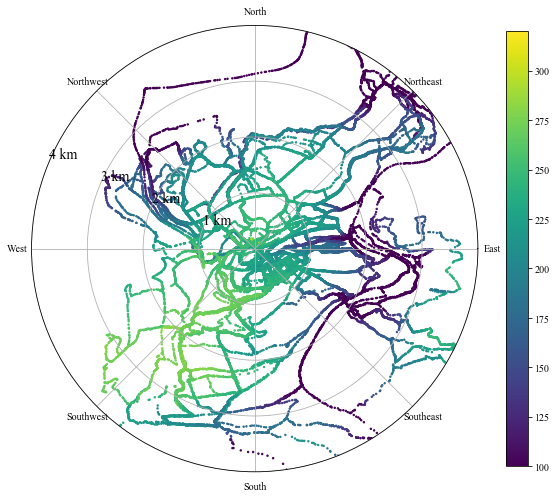

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
plt.scatter(bearingvec2, distancevec, c=elevations, s=2, vmin=100., vmax=320.)
plt.colorbar(shrink=0.8)
lines, labels = plt.thetagrids( range(0,360,45), ('East', 'Northeast', 'North', 'Northwest', 
                                                  'West','Southwest', 'South', 'Southeast') )

lines, labels = plt.rgrids( np.arange(0., 12.1, 2.0), 
                           ("", "2 km", "4 km", "6 km", "8 km", "10 km", "12 km" ),
                           angle=157., fontsize=14)
plt.savefig(os.path.join(figdir, 'polar_scatter_altitude.png'), dpi=300, bbox_inches="tight")

# Zoom
lines, labels = plt.rgrids( np.arange(0., 4.1, 1.0), 
                           ("", "1 km", "2 km", "3 km", "4 km" ),
                           angle=157., fontsize=14)
plt.ylim(0, 4.)
plt.savefig(os.path.join(figdir, 'polar_scatter_altitude_zoom.png'), dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'polar_scatter_altitude_zoom.jpg'), dpi=300, bbox_inches="tight")

plt.show()
plt.close()

### Pseudo-color 
The goal is to count count how many times we've been in different subregions.

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10


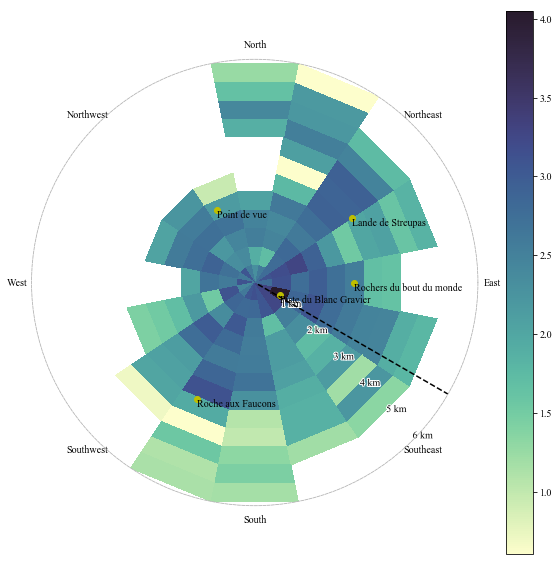

In [23]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
# Histogramming
ntheta = 16
r_edges = np.arange(0, 6.01, 0.5)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1) + np.pi/16.
H, _, _ = np.histogram2d(distancevec, bearingvec2, [r_edges, theta_edges])

H = np.ma.masked_equal(H, 0., copy=True)

# Plot
Theta, R = np.meshgrid(theta_edges, r_edges)
pcm = ax.pcolormesh(Theta, R, np.log10(H), cmap=cmocean.cm.deep)
lines, labels = plt.thetagrids( range(0,360,45), ('East', 'Northeast', 'North', 'Northwest', 
                                                  'West','Southwest', 'South', 'Southeast') )

lines, labels = plt.rgrids(np.arange(0., 6.1, 1.0), 
                           ("", "1 km", "2 km", "3 km", "4 km", "5 km", "6 km" ),
                          angle=-45.)

for ll in labels[1:]:
    ll.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

# Points of interest
for p in pointsInterest:
    bearing = np.deg2rad(sphere.bearing((lat0, lon0), (p[0], p[1])))
    dist = distance.vincenty((lat0, lon0), (p[0], p[1])).kilometers
    ax.plot(bearing, dist, "yo")
    ax.text(bearing, dist, p[-1], ha="left", va="top")
    
ax.plot((-np.pi/6., -np.pi/6.), (0.1, 6), 'k--')
extax = ax.axes.spines['polar']
#extax.set_visible(False)
extax.set_linestyle("--")
extax.set_color("0.7")
plt.colorbar(pcm)
# plt.savefig(os.path.join(figdir, 'polar_pcolor.png'), dpi=300, bbox_inches="tight")
# plt.savefig(os.path.join(figdir, 'polar_pcolor.jpg'), dpi=300, bbox_inches="tight")
plt.show()
plt.close()